In [1]:
import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import re

In [2]:
path = r'../data/housing.csv'

In [3]:
df = pd.read_csv(path)

In [4]:
# size
df.shape

(20640, 10)

In [5]:
cols_to_use = ['latitude',
'longitude',
'housing_median_age',
'total_rooms',
'total_bedrooms',
'population',
'households',
'median_income',
'median_house_value',
'ocean_proximity']

In [6]:
df = df[cols_to_use].copy()

In [7]:
# top 5
df.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,37.88,-122.23,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,37.86,-122.22,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,37.85,-122.24,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,37.85,-122.25,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,37.85,-122.25,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
# missing?
df.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

### Data preparation

In [9]:
# fill missing values with 0
df['total_bedrooms'].fillna(0, inplace=True)

In [10]:
df.isnull().sum()

latitude              0
longitude             0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [11]:
# log transform to median_house_value
df['median_house_value'] = np.log1p(df['median_house_value'])

In [12]:
# create train-test-val splits
train_df, test_df = train_test_split(df, test_size=0.2, random_state=1)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=1)

In [13]:
train_y = train_df['median_house_value']
val_y = val_df['median_house_value']
test_y = test_df['median_house_value']

In [14]:
del train_df['median_house_value']
del val_df['median_house_value']
del test_df['median_house_value']

In [15]:
dv = DictVectorizer(sparse=False)

In [16]:
def data_prep(x, is_train=True):
    dicts = x.to_dict(orient='records')
    if is_train:
        dv.fit(dicts)
    X = pd.DataFrame(dv.transform(dicts), columns=dv.get_feature_names_out())
    return X
    

In [17]:
train_df = data_prep(train_df)
val_df = data_prep(val_df, is_train=False)

In [18]:
train_df.head()

,households,housing_median_age,latitude,longitude,median_income,ocean_proximity=<1H OCEAN,ocean_proximity=INLAND,ocean_proximity=ISLAND,ocean_proximity=NEAR BAY,ocean_proximity=NEAR OCEAN,population,total_bedrooms,total_rooms
0,578.0,19.0,34.63,-118.18,4.1573,0.0,1.0,0.0,0.0,0.0,1677.0,606.0,3562.0
1,50.0,10.0,34.69,-116.90,0.4999,0.0,1.0,0.0,0.0,0.0,108.0,102.0,337.0
2,462.0,27.0,33.78,-118.26,2.0458,0.0,0.0,0.0,0.0,1.0,1723.0,491.0,1672.0
3,1056.0,5.0,34.17,-117.33,2.9877,0.0,1.0,0.0,0.0,0.0,2564.0,1140.0,4718.0
4,272.0,42.0,35.35,-119.02,1.9830,0.0,1.0,0.0,0.0,0.0,776.0,251.0,1239.0


### q1

Let's train a decision tree regressor to predict the median_house_value variable.

Train a model with max_depth=1.
Which feature is used for splitting the data?

In [19]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(train_df, train_y)

DecisionTreeRegressor(max_depth=1)

In [20]:
print(export_text(dt, feature_names=dv.get_feature_names_out().tolist))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



/Users/home/.local/share/virtualenvs/hw6-sqtI3tEy/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### q2

Train a random forest model with these parameters:

- n_estimators=10
- random_state=1
- n_jobs=-1 (optional - to make training faster)

What's the RMSE of this model on validation?

In [21]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(train_df, train_y)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [22]:
y_pred = rf.predict(val_df)
np.sqrt(mean_squared_error(val_y, y_pred))

0.24579193759466622

### q3

Now let's experiment with the n_estimators parameter

- Try different values of this parameter from 10 to 200 with step 10.
- Set random_state to 1.
- Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving?

In [23]:
scores = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(train_df, train_y)
    
    y_pred = rf.predict(val_df)
    score = np.sqrt(mean_squared_error(val_y, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

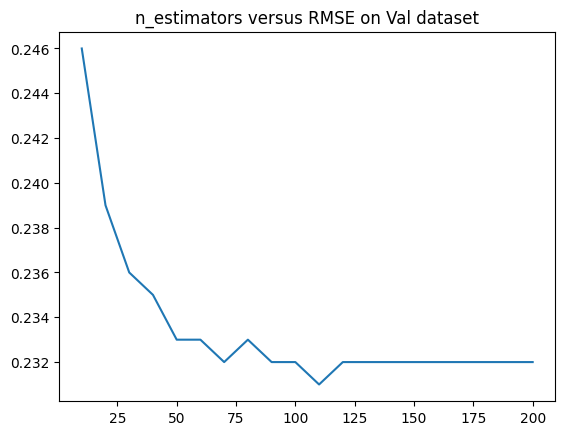

In [24]:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))
plt.title('n_estimators versus RMSE on Val dataset')
plt.show()

### q4

Let's select the best max_depth:

- Try different values of max_depth: [10, 15, 20, 25]
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10)
- Fix the random seed: random_state=1
    
What's the best max_depth:

In [25]:
scores = []

depths = [10, 15, 20, 25]
for depth in depths:
    rf = RandomForestRegressor(n_estimators=0,
                               max_depth=depth,
                               random_state=1, n_jobs=-1,
                               warm_start=True)

    for n in range(10, 201, 10):
        rf.n_estimators = n
        rf.fit(train_df, train_y)

        y_pred = rf.predict(val_df)
        score = np.sqrt(mean_squared_error(val_y, y_pred))

        scores.append((depth, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

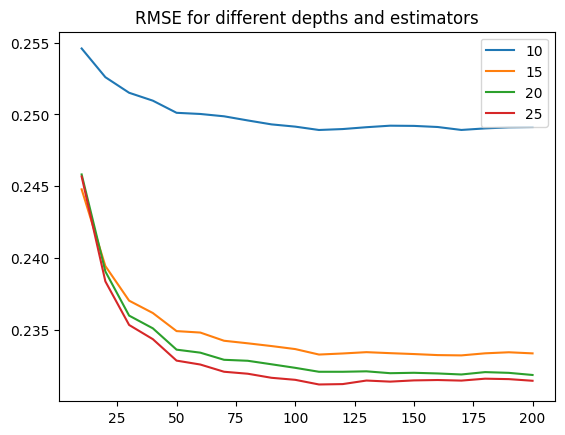

In [26]:
for d in depths:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()
plt.title('RMSE for different depths and estimators')
plt.show()

### q5

Train the model with these parametes:
- n_estimators=10,
- max_depth=20,
- random_state=1,
- n_jobs=-1 (optional)

Get the feature importance information from this model

What's the most important feature?

In [27]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, 
                           random_state=1, n_jobs=-1)
rf.fit(train_df, train_y)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [28]:
rf.feature_importances_

array([1.61407558e-02, 3.31967386e-02, 1.01333351e-01, 9.63405488e-02,
       3.63224176e-01, 2.76524800e-03, 3.10900842e-01, 3.56806263e-04,
       4.52770519e-04, 4.45219202e-03, 3.09988869e-02, 1.93726028e-02,
       2.04650818e-02])

In [29]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.get_feature_names_out()
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(['importance'], ascending=False)

,feature,importance
4,median_income,0.363224
6,ocean_proximity=INLAND,0.310901
2,latitude,0.101333
3,longitude,0.096341
1,housing_median_age,0.033197
10,population,0.030999
12,total_rooms,0.020465
11,total_bedrooms,0.019373
0,households,0.016141
9,ocean_proximity=NEAR OCEAN,0.004452


### q6

- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

Now change eta from 0.3 to 0.1.

Which eta leads to the best RMSE score on the validation dataset?

In [30]:
features = dv.get_feature_names_out()
features = [feature.replace('<', '') if '<' in feature else feature for feature in features ]
dtrain = xgb.DMatrix(train_df, label=train_y, feature_names=features)
dval = xgb.DMatrix(val_df, label=val_y, feature_names=features)

In [31]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [32]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [33]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [34]:
scores = {}
scores['eta=0.3'] = parse_xgb_output(output)

In [35]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [36]:
scores['eta=0.1'] = parse_xgb_output(output)

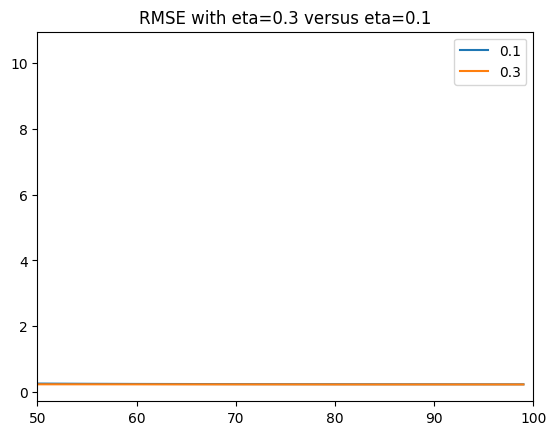

In [37]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_rmse,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_rmse,
        label='0.3')
plt.legend()

#plt.ylim([0.43, 0.45])
plt.xlim([50, 100])
plt.title('RMSE with eta=0.3 versus eta=0.1')
plt.show()